In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import io

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

from Levenberg_Marquardt import LevenbergMarquardt

# Read mnist data from the mat file
mnist_data = io.loadmat("./mnist2.mat")
imgs_train = mnist_data['imgs_train']
imgs_test = mnist_data['imgs_test']
labels_train = np.squeeze(mnist_data['labels_train'])
labels_test = np.squeeze(mnist_data['labels_test'])

In [7]:
# change to 60000 * 20 * 20
imgs_train = imgs_train.transpose(2, 0, 1)
imgs_test = imgs_test.transpose(2, 0, 1)

In [8]:
# Filter samples labeled 1 and 7 in imgs_train
train_filter = np.isin(labels_train, [1, 7])
imgs_train_17 = imgs_train[train_filter]
labels_train_17 = labels_train[train_filter]

# Filter samples labeled 1 and 7 in imgs_test
test_filter = np.isin(labels_test, [1, 7])
imgs_test_17 = imgs_test[test_filter]
labels_test_17 = labels_test[test_filter]

print(f"Filtered training data shape: {imgs_train_17.shape}")
print(f"Filtered training labels shape: {labels_train_17.shape}")
print(f"Filtered test data shape: {imgs_test_17.shape}")
print(f"Filtered test labels shape: {labels_test_17.shape}")

Filtered training data shape: (13007, 20, 20)
Filtered training labels shape: (13007,)
Filtered test data shape: (2163, 20, 20)
Filtered test labels shape: (2163,)


In [ ]:
# save 20 components
NPCA = 20

def do_pca(dataset, n_components):
    data_flattened = dataset.reshape(dataset.shape[0], -1)
    print(f"data shape before PCA: {data_flattened.shape}")
    
    scaler = StandardScaler()
    data_standardized = scaler.fit_transform(data_flattened)
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data_standardized)
    print(f"data shape after PCA: {data_pca.shape}")
    
    return data_pca

X_train = do_pca(imgs_train_17, NPCA)
lbl_train = labels_train_17

X_test = do_pca(imgs_test_17, NPCA)
lbl_test = labels_test_17

data shape before PCA: (13007, 400)
data shape after PCA: (13007, 25)
data shape before PCA: (2163, 400)
data shape after PCA: (2163, 25)


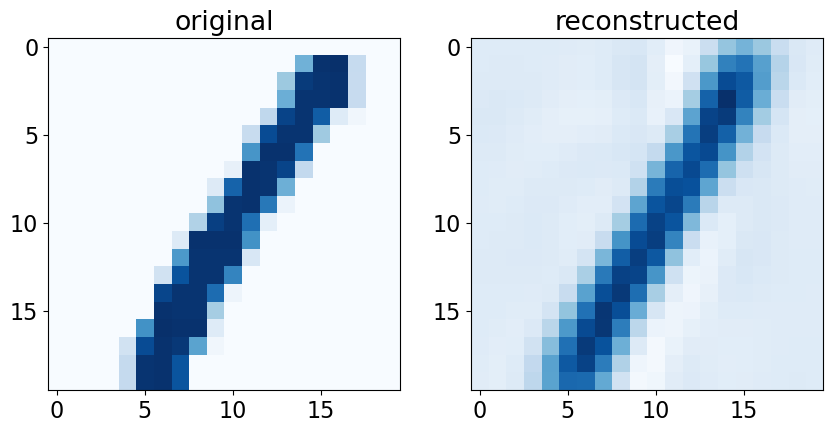

In [45]:
imgs_train_flattened = imgs_train_17.reshape(imgs_train_17.shape[0], -1)

# standardize the data to zero mean and unit variance
scaler = StandardScaler()
imgs_train_standardized = scaler.fit_transform(imgs_train_flattened)

pca = PCA(n_components=NPCA)
imgs_train_pca = pca.fit_transform(imgs_train_standardized)

# reconstruct the data
imgs_train_reconstructed = pca.inverse_transform(imgs_train_pca)

imgs_train_reconstructed_original = scaler.inverse_transform(imgs_train_reconstructed)

imgs_train_reconstructed_reshaped = imgs_train_reconstructed_original.reshape(imgs_train_17.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(imgs_train_17[0], cmap='Blues')
axes[0].set_title("original")

axes[1].imshow(imgs_train_reconstructed_reshaped[0], cmap='Blues')
axes[1].set_title("reconstructed")

plt.show()

In [46]:
# Define functions for finding the optimal dividing surface
def logloss_quadratic(X,y,w):
    return 0.5*np.sum((np.log(1. + np.exp(-myquadratic(X,y,w))))**2)

def Res_and_Jac(X,y,w):
    # the vector of residuals r
    aux = np.exp(-myquadratic(X,y,w))
    r = np.log(1. + aux)
    # the Jacobian matrix J[i,j] = dr[i]/dx[j]
    a = -aux/(1. + aux)
    n,d = np.shape(X)
    d2 = d*d
    ya = y*a
    qterm = np.zeros((n,d2))
    for k in range(n):
        xk = X[k,:]
        xx = np.outer(xk,xk)
        qterm[k,:] = np.reshape(xx,(np.size(xx),))
    J = np.concatenate((qterm,X,np.ones((n,1))),axis = 1)   
    for k in range(n):
        J[k,:] = J[k,:]*ya[k]
    return r,J

def myquadratic(X,y,w):
    d = np.size(X,axis = 1)
    d2 = d*d
    W = np.reshape(w[:d2],(d,d))
    v = w[d2:d2+d];
    b = w[-1]
    qterm = np.diag(X@W@np.transpose(X))
    q = y*qterm + (np.outer(y,np.ones((d,)))*X)@v + y*b
    return q

# Call Levenberg-Marquardt
d = NPCA
def r_and_J(w):
    return Res_and_Jac(X_train,lbl_train,w)
# The quadratic surface is of the form x^\top W x + v x + b 
# The total number of parameters in W,v,b is d^2 + d + 1
# The initial guess: all parameters are ones
w = np.ones((d*d + d + 1,))
iter_max = 600
tol = 1e-3
w,Niter,Loss_vals,gradnorm_vals = LevenbergMarquardt(r_and_J,w,iter_max,tol)
# print(w)

iter 0: loss =  18.56873339087987  gradnorm =  3180.2686812989946
LM, iter #1: loss = 1.4273e+03, gradnorm = 3.1803e+03, rho = -7.5946e+01, R = 5.0000e-02
LM, iter #2: loss = 2.3457e+00, gradnorm = 1.2536e+03, rho = 7.6951e+01, R = 1.0000e-01
LM, iter #3: loss = 1.0810e+00, gradnorm = 4.4803e+03, rho = 5.3943e-01, R = 1.0000e-01
LM, iter #4: loss = 3.5256e-01, gradnorm = 1.0814e+03, rho = 6.7391e-01, R = 1.0000e-01
LM, iter #5: loss = 4.0125e-02, gradnorm = 1.4106e+02, rho = 8.8622e-01, R = 2.0000e-01
LM, iter #6: loss = 5.1468e-03, gradnorm = 1.8900e+01, rho = 8.7174e-01, R = 4.0000e-01
LM, iter #7: loss = 6.8356e-04, gradnorm = 2.5493e+00, rho = 8.6720e-01, R = 8.0000e-01
LM, iter #8: loss = 9.1898e-05, gradnorm = 3.4460e-01, rho = 8.6559e-01, R = 1.0000e+00
LM, iter #9: loss = 1.2410e-05, gradnorm = 4.6616e-02, rho = 8.6504e-01, R = 1.0000e+00
LM, iter #10: loss = 1.6792e-06, gradnorm = 6.3079e-03, rho = 8.6490e-01, R = 1.0000e+00
LM, iter #11: loss = 2.2766e-07, gradnorm = 8.5363e-

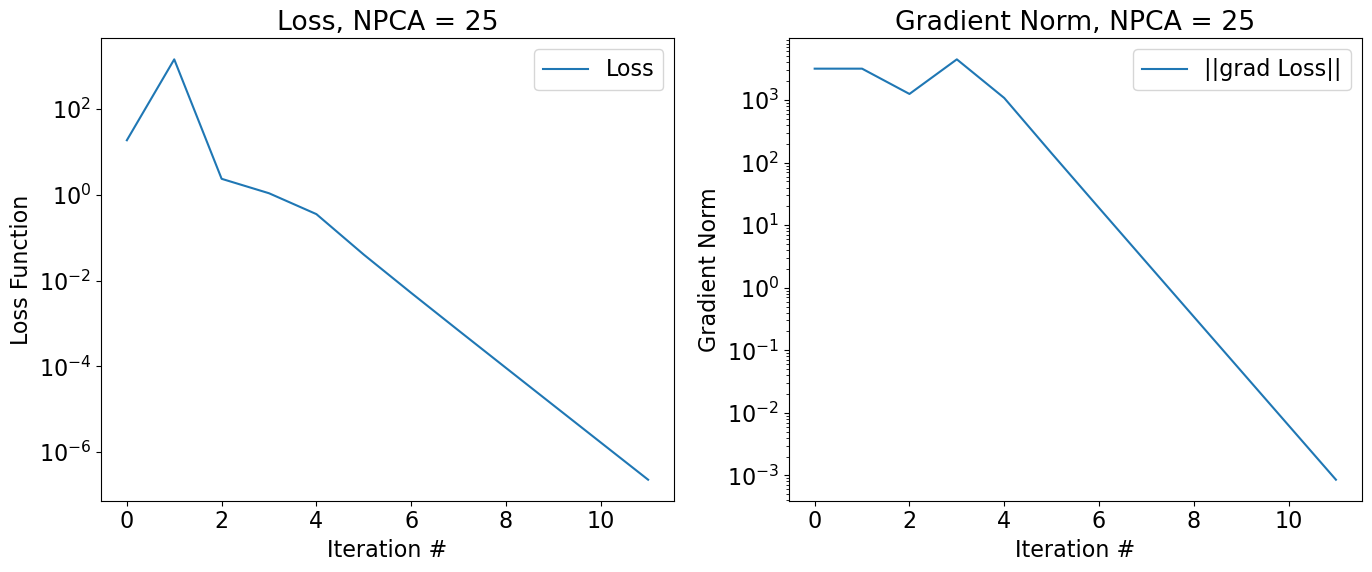

In [ ]:
# # Plot the learning curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(Loss_vals, label="Loss")
ax1.set_xlabel("Iteration #")
ax1.set_ylabel("Loss Function")
ax1.set_yscale("log")
ax1.set_title(f"Loss, NPCA = {NPCA}")
ax1.legend()

ax2.plot(gradnorm_vals, label="||grad Loss||")
ax2.set_xlabel("Iteration #")
ax2.set_ylabel("Gradient Norm")
ax2.set_yscale("log")
ax2.set_title(f"Gradient Norm, NPCA = {NPCA}")
ax2.legend()

plt.tight_layout()
plt.show()

In [48]:
# Apply the learned classifier to the test set
test0 = myquadratic(X_train,lbl_train,w)
hits = np.argwhere(test0 > 0)
misses = np.argwhere(test0 < 0)
Nhits0 = np.size(hits)
Nmisses0 = np.size(misses)
print(f"TRAIN SET: {Nhits0} are classified correctly, {Nmisses0} are misclassified")

test = myquadratic(X_test,lbl_test,w)
hits = np.argwhere(test > 0)
misses = np.argwhere(test < 0)
Nhits = np.size(hits)
Nmisses = np.size(misses)
print(f"TEST SET: {Nhits} are classified correctly, {Nmisses} are misclassified")
misses = np.squeeze(misses)
print("Misses in the test set: ",misses)

TRAIN SET: 13007 are classified correctly, 0 are misclassified
TEST SET: 2138 are classified correctly, 25 are misclassified
Misses in the test set:  [  16  134  168  249  623  644  731  916 1014 1069 1132 1152 1534 1535
 1605 1651 1705 1709 1710 1725 1767 1842 2004 2062 2068]


data shape before PCA: (13007, 400)
data shape after PCA: (13007, 1)
data shape before PCA: (2163, 400)
data shape after PCA: (2163, 1)
iter 0: loss =  12.123100210645621  gradnorm =  29.99277061383463
LM, iter #1: loss = 7.5467e+00, gradnorm = 1.7236e+01, rho = 9.0398e-01, R = 4.0000e-01
LM, iter #2: loss = 3.1239e+00, gradnorm = 6.6619e+00, rho = 8.6767e-01, R = 8.0000e-01
LM, iter #3: loss = 6.0983e-01, gradnorm = 1.2904e+00, rho = 8.4725e-01, R = 1.0000e+00
LM, iter #4: loss = 8.4844e-02, gradnorm = 1.8263e-01, rho = 8.6196e-01, R = 1.0000e+00
LM, iter #5: loss = 1.1605e-02, gradnorm = 2.5145e-02, rho = 8.6339e-01, R = 1.0000e+00
LM, iter #6: loss = 1.5639e-03, gradnorm = 3.4013e-03, rho = 8.6528e-01, R = 1.0000e+00
LM, iter #7: loss = 2.1145e-04, gradnorm = 4.6046e-04, rho = 8.6507e-01, R = 1.0000e+00
data shape before PCA: (13007, 400)
data shape after PCA: (13007, 2)
data shape before PCA: (2163, 400)
data shape after PCA: (2163, 2)
iter 0: loss =  18.823667284491513  gradnorm =

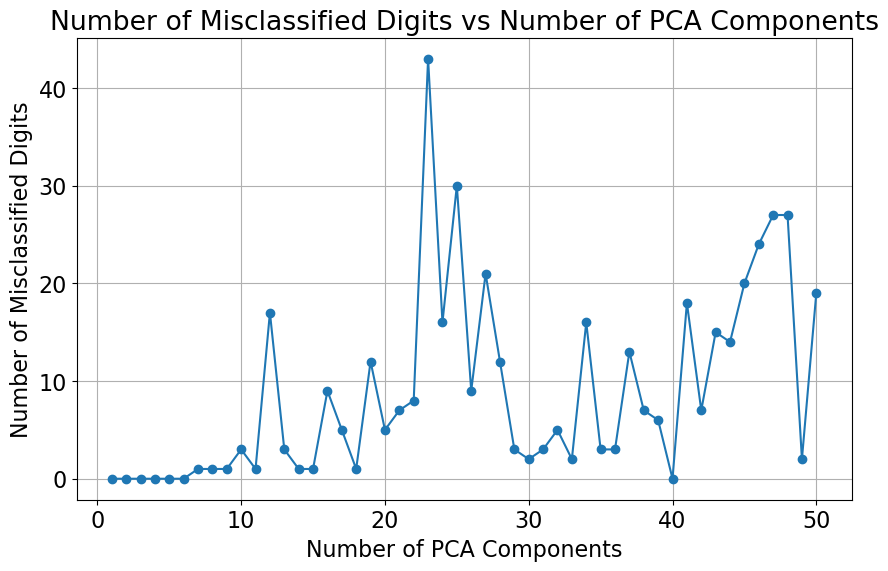

In [50]:
# Define a range of PCA components to test
pca_components = range(1, 51, 1)
misclassified_counts = []

for n_components in pca_components:
    # Perform PCA on the training and test sets
    X_train_pca = do_pca(imgs_train_17, n_components)
    X_test_pca = do_pca(imgs_test_17, n_components)
    
    # Train the classifier using Levenberg-Marquardt
    d = n_components
    def r_and_J(w):
        return Res_and_Jac(X_train_pca, lbl_train, w)
    
    w = np.ones((d*d + d + 1,))
    iter_max = 600
    tol = 1e-3
    w, Niter, Loss_vals, gradnorm_vals = LevenbergMarquardt(r_and_J, w, iter_max, tol)
    
    # Apply the classifier to the test set
    test = myquadratic(X_test_pca, lbl_test, w)
    misses = np.argwhere(test < 0)
    Nmisses = np.size(misses)
    
    # Record the number of misclassified digits
    misclassified_counts.append(Nmisses)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(pca_components, misclassified_counts, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Number of Misclassified Digits')
plt.title('Number of Misclassified Digits vs Number of PCA Components')
plt.grid(True)
plt.show()

data shape before PCA: (13007, 400)
data shape after PCA: (13007, 20)
data shape before PCA: (2163, 400)
data shape after PCA: (2163, 20)


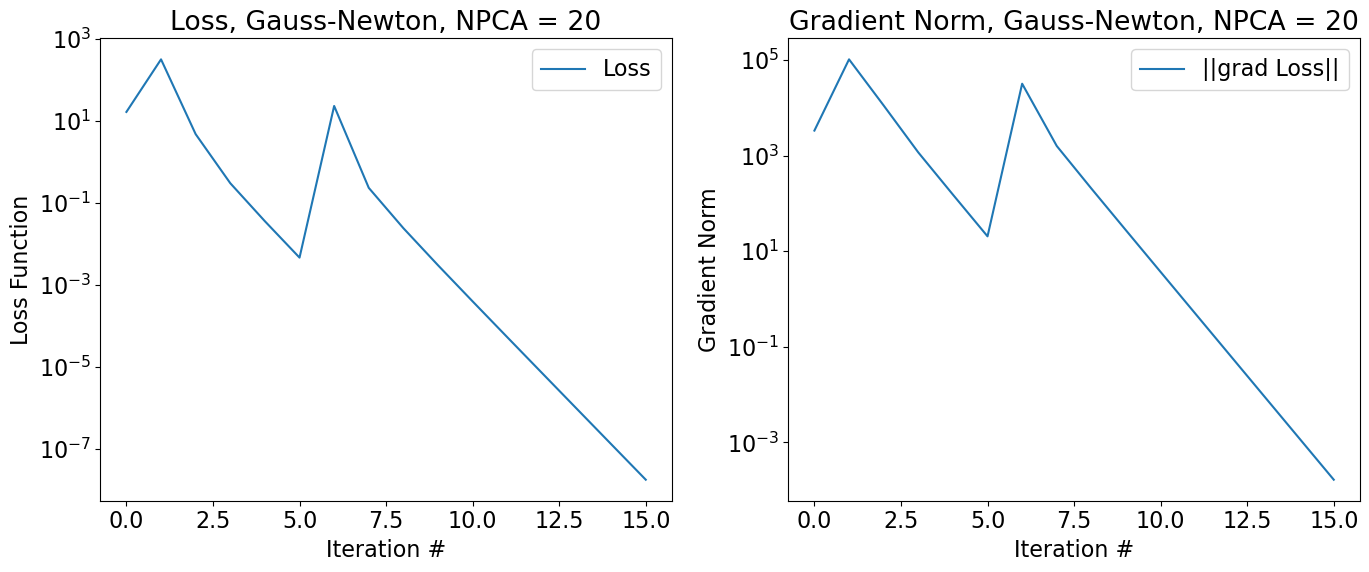

In [52]:
# Set the number of PCA components to 20
NPCA = 20

# Perform PCA on the training and test sets
X_train_pca = do_pca(imgs_train_17, NPCA)
X_test_pca = do_pca(imgs_test_17, NPCA)

# Define the Gauss-Newton algorithm
def gauss_newton(r_and_J, w, iter_max, tol):
    Loss_vals = []
    gradnorm_vals = []
    for i in range(iter_max):
        r, J = r_and_J(w)
        JTJ = J.T @ J + np.eye(J.shape[1]) * 1e-6  # Regularize J.T @ J
        JTJ_inv = np.linalg.inv(JTJ)
        grad = J.T @ r
        delta_w = -JTJ_inv @ grad
        w = w + delta_w
        
        loss = 0.5 * np.sum(r**2)
        grad_norm = np.linalg.norm(grad)
        
        Loss_vals.append(loss)
        gradnorm_vals.append(grad_norm)
        
        if grad_norm < tol:
            break
    
    return w, i+1, np.array(Loss_vals), np.array(gradnorm_vals)

# Solve the nonlinear least squares problem using the Gauss-Newton algorithm
d = NPCA
def r_and_J(w):
    return Res_and_Jac(X_train_pca, lbl_train, w)

w = np.ones((d*d + d + 1,))
iter_max = 600
tol = 1e-3
w, Niter, Loss_vals, gradnorm_vals = gauss_newton(r_and_J, w, iter_max, tol)

# Plot the graphs of the loss and the norm of the gradient versus iteration number
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(Loss_vals, label="Loss")
ax1.set_xlabel("Iteration #")
ax1.set_ylabel("Loss Function")
ax1.set_yscale("log")
ax1.set_title(f"Loss, Gauss-Newton, NPCA = {NPCA}")
ax1.legend()

ax2.plot(gradnorm_vals, label="||grad Loss||")
ax2.set_xlabel("Iteration #")
ax2.set_ylabel("Gradient Norm")
ax2.set_yscale("log")
ax2.set_title(f"Gradient Norm, Gauss-Newton, NPCA = {NPCA}")
ax2.legend()

plt.tight_layout()
plt.show()